In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
!unzip -q drive/'My Drive'/dataset-original.zip

In [0]:
!mkdir dataset-validation
!mkdir dataset-validation/cardboard
!mkdir dataset-validation/glass
!mkdir dataset-validation/paper
!mkdir dataset-validation/plastic
!mkdir dataset-validation/metal
!mkdir dataset-validation/trash
!mkdir dataset-test
!mkdir dataset-test/cardboard
!mkdir dataset-test/glass
!mkdir dataset-test/paper
!mkdir dataset-test/plastic
!mkdir dataset-test/metal
!mkdir dataset-test/trash

In [0]:
!shuf -n 125 -e dataset-original/glass/* | xargs -i mv {} dataset-validation/glass/
!shuf -n 125 -e dataset-original/glass/* | xargs -i mv {} dataset-test/glass/
!shuf -n 148 -e dataset-original/paper/* | xargs -i mv {} dataset-validation/paper/
!shuf -n 149 -e dataset-original/paper/* | xargs -i mv {} dataset-test/paper/
!shuf -n 100 -e dataset-original/cardboard/* | xargs -i mv {} dataset-validation/cardboard/
!shuf -n 100 -e dataset-original/cardboard/* | xargs -i mv {} dataset-test/cardboard/
!shuf -n 120 -e dataset-original/plastic/* | xargs -i mv {} dataset-validation/plastic/
!shuf -n 121 -e dataset-original/plastic/* | xargs -i mv {} dataset-test/plastic/
!shuf -n 102 -e dataset-original/metal/* | xargs -i mv {} dataset-validation/metal/
!shuf -n 103 -e dataset-original/metal/* | xargs -i mv {} dataset-test/metal/
!shuf -n 33 -e dataset-original/trash/* | xargs -i mv {} dataset-validation/trash/
!shuf -n 34 -e dataset-original/trash/* | xargs -i mv {} dataset-test/trash/

In [7]:
!ls dataset-original/glass | wc -l
!ls dataset-validation/glass | wc -l
!ls dataset-test/glass | wc -l

251
125
125


In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import numpy as np

In [0]:
transformationsTrain = transforms.Compose([transforms.Resize(299), transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(),
                                           transforms.RandomRotation(degrees = (90, -90)), transforms.ToTensor(), 
                                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transformationsValidation = transforms.Compose([transforms.Resize(255), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transformationsTest = transforms.Compose([transforms.Resize(255), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [0]:
train_set = datasets.ImageFolder("dataset-original", transform = transformationsTrain)
val_set = datasets.ImageFolder("dataset-validation", transform = transformationsValidation)
test_set = datasets.ImageFolder("dataset-test", transform = transformationsTest)

In [0]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=25, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size =25, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size =25, shuffle=True)

In [0]:
!/opt/bin/nvidia-smi
!ps -aux|grep python

Mon Dec  2 20:16:41 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# torch.cuda.empty_cache()
# !kill -9 877

In [0]:
model = torchvision.models.densenet161(pretrained=True)
model.cuda()

minibatches = 5

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

train_losses, train_accs = [], []
val_losses, val_accs = [], []

for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    model.train()
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        pred = outputs.data.max(1)[1]
        matches = labels == pred
        accuracy = matches.float().mean()

        # print statistics
        running_loss += loss.item()
        if i % minibatches == minibatches - 1:    # print every n mini-batches
            print('[%d, %5d] loss: %.3f accuracy: %.3f itemLoss: %.3f' %
                  (epoch + 1, i + 1, running_loss / minibatches, accuracy, loss.item()))
            running_loss = 0.0

        train_losses.append(loss.item())
        train_accs.append(accuracy.item())
    
    model.eval()
    val_loss, correct = 0., 0
    total = 0
    with torch.no_grad():
      for data in val_loader:
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = model(inputs)
        val_loss += criterion(outputs, labels).item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the validation images: %f %%' % (
    100 * correct / total))

    val_loss /= len(val_loader)
    acc = correct / len(val_loader)

    val_losses.append(val_loss)
    val_accs.append(acc)

print('Finished Training')

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:01<00:00, 58.8MB/s]


[1,     5] loss: 6.500 accuracy: 0.120 itemLoss: 4.595
[1,    10] loss: 2.348 accuracy: 0.640 itemLoss: 1.688
[1,    15] loss: 1.449 accuracy: 0.680 itemLoss: 1.197
[1,    20] loss: 1.098 accuracy: 0.680 itemLoss: 0.860
[1,    25] loss: 0.869 accuracy: 0.760 itemLoss: 0.752
[1,    30] loss: 0.858 accuracy: 0.520 itemLoss: 1.518
[1,    35] loss: 0.789 accuracy: 0.680 itemLoss: 1.065
[1,    40] loss: 0.704 accuracy: 0.720 itemLoss: 0.995
[1,    45] loss: 0.752 accuracy: 0.800 itemLoss: 0.601
[1,    50] loss: 0.492 accuracy: 0.800 itemLoss: 0.500
Accuracy of the network on the validation images: 85.350318 %
[2,     5] loss: 0.410 accuracy: 0.800 itemLoss: 0.640
[2,    10] loss: 0.429 accuracy: 0.840 itemLoss: 0.521
[2,    15] loss: 0.514 accuracy: 0.760 itemLoss: 0.433
[2,    20] loss: 0.476 accuracy: 0.680 itemLoss: 0.839
[2,    25] loss: 0.384 accuracy: 0.920 itemLoss: 0.420
[2,    30] loss: 0.433 accuracy: 0.760 itemLoss: 0.542
[2,    35] loss: 0.355 accuracy: 0.920 itemLoss: 0.262
[2,

In [0]:
# torch.save(model.state_dict(), "/content/drive/My Drive/modelTwoDec2.pt")

In [0]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 94 %


In [0]:
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [0]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    all_labels = torch.tensor([])
    all_labels = all_labels.cuda()
    all_preds = all_preds.cuda()
    for batch in loader:
        images, labels = batch
        images = images.cuda()
        labels = labels.float().cuda()
        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
        all_labels = torch.cat((all_labels, labels), dim=0)
    return all_preds, all_labels

In [0]:
model.eval()

with torch.no_grad():
    prediction_loader = test_loader
    test_preds, test_labels = get_all_preds(model, prediction_loader)

In [0]:
test_labels.shape
# torch.Tensor(val_preds.argmax(dim=1)).shape

torch.Size([632])

In [0]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [0]:
preds_correct = get_num_correct(test_preds, test_labels)

print('total correct:', preds_correct)
print('accuracy:', preds_correct / len(test_set))

total correct: 595
accuracy: 0.9414556962025317


In [0]:
stacked = torch.stack(
    (
        test_labels
        ,test_preds.argmax(dim=1).float()
    )
    ,dim=1
)

In [0]:
cmt = torch.zeros(6, 6, dtype=torch.int64)
stacked.shape

torch.Size([632, 2])

In [0]:
for p in stacked.int():
    tl, pl = p.tolist()
    cmt[tl, pl] = cmt[tl, pl] + 1

cmt

tensor([[ 89,   0,   1,   9,   0,   1],
        [  0, 121,   3,   1,   0,   0],
        [  0,   1, 101,   0,   0,   1],
        [  1,   1,   0, 144,   1,   2],
        [  1,   3,   4,   1, 112,   0],
        [  1,   1,   2,   1,   1,  28]])

In [0]:
from sklearn.metrics import confusion_matrix

In [0]:
cm = confusion_matrix(test_labels.cpu(), test_preds.argmax(dim=1).cpu())


In [0]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    print(plt.ylim())
    plt.ylim(5.5, -0.5)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
class_names = ('cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash')

Confusion matrix, without normalization
[[ 89   0   1   9   0   1]
 [  0 121   3   1   0   0]
 [  0   1 101   0   0   1]
 [  1   1   0 144   1   2]
 [  1   3   4   1 112   0]
 [  1   1   2   1   1  28]]
(5.0, 0.0)


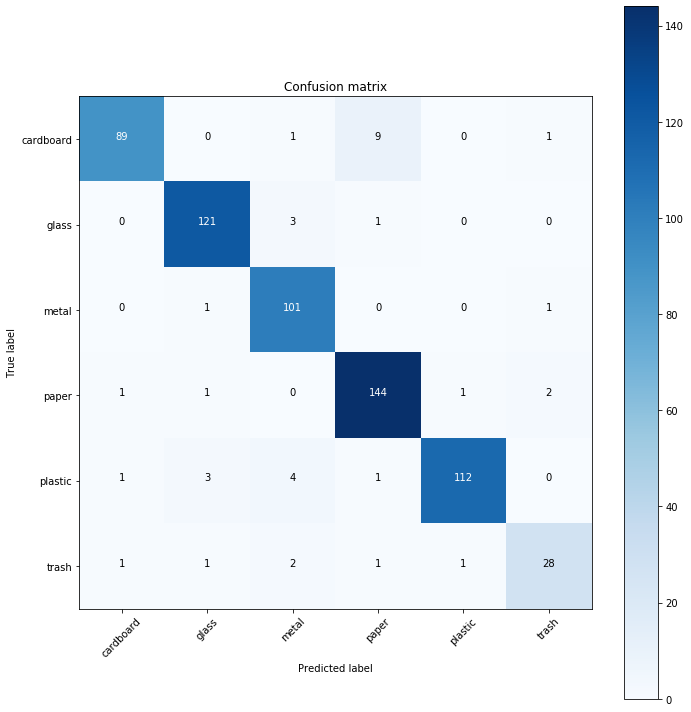

In [0]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, class_names)

In [0]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    model.train()
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        pred = outputs.data.max(1)[1]
        matches = labels == pred
        accuracy = matches.float().mean()

        # print statistics
        running_loss += loss.item()
        if i % minibatches == minibatches - 1:    # print every n mini-batches
            print('[%d, %5d] loss: %.3f accuracy: %.3f itemLoss: %.3f' %
                  (epoch + 1, i + 1, running_loss / minibatches, accuracy, loss.item()))
            running_loss = 0.0

        train_losses.append(loss.item())
        train_accs.append(accuracy.item())
    
    model.eval()
    val_loss, correct = 0., 0
    total = 0
    with torch.no_grad():
      for data in val_loader:
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = model(inputs)
        val_loss += criterion(outputs, labels).item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the validation images: %f %%' % (
    100 * correct / total))

    val_loss /= len(val_loader)
    acc = correct / len(val_loader)

    val_losses.append(val_loss)
    val_accs.append(acc)

print('Finished Training')

[1,     5] loss: 0.035 accuracy: 1.000 itemLoss: 0.023
[1,    10] loss: 0.034 accuracy: 1.000 itemLoss: 0.011
[1,    15] loss: 0.048 accuracy: 0.960 itemLoss: 0.154
[1,    20] loss: 0.075 accuracy: 1.000 itemLoss: 0.008
[1,    25] loss: 0.055 accuracy: 0.960 itemLoss: 0.147
[1,    30] loss: 0.033 accuracy: 1.000 itemLoss: 0.019
[1,    35] loss: 0.045 accuracy: 1.000 itemLoss: 0.010
[1,    40] loss: 0.092 accuracy: 1.000 itemLoss: 0.014
[1,    45] loss: 0.037 accuracy: 1.000 itemLoss: 0.009
[1,    50] loss: 0.026 accuracy: 1.000 itemLoss: 0.058
Accuracy of the network on the validation images: 94.426752 %
[2,     5] loss: 0.031 accuracy: 1.000 itemLoss: 0.056
[2,    10] loss: 0.018 accuracy: 1.000 itemLoss: 0.023
[2,    15] loss: 0.028 accuracy: 1.000 itemLoss: 0.028
[2,    20] loss: 0.043 accuracy: 0.960 itemLoss: 0.060
[2,    25] loss: 0.051 accuracy: 0.960 itemLoss: 0.086
[2,    30] loss: 0.053 accuracy: 1.000 itemLoss: 0.026
[2,    35] loss: 0.026 accuracy: 1.000 itemLoss: 0.021
[2,

In [0]:
# torch.save(model.state_dict(), "/content/drive/My Drive/modelThreeDec2.pt")

In [0]:
model.eval()

with torch.no_grad():
    prediction_loader = test_loader
    test_preds, test_labels = get_all_preds(model, prediction_loader)

In [0]:
preds_correct = get_num_correct(test_preds, test_labels)

print('total correct:', preds_correct)
print('accuracy:', preds_correct / len(test_set))

total correct: 603
accuracy: 0.9541139240506329


In [0]:
stacked = torch.stack(
    (
        test_labels
        ,test_preds.argmax(dim=1).float()
    )
    ,dim=1
)

In [0]:
cmt = torch.zeros(6, 6, dtype=torch.int64)
stacked.shape

for p in stacked.int():
    tl, pl = p.tolist()
    cmt[tl, pl] = cmt[tl, pl] + 1

cmt

tensor([[ 95,   0,   1,   3,   1,   0],
        [  0, 123,   1,   0,   1,   0],
        [  0,   1, 100,   0,   1,   1],
        [  1,   0,   0, 143,   3,   2],
        [  0,   1,   2,   1, 117,   0],
        [  1,   1,   2,   1,   4,  25]])

Confusion matrix, without normalization
[[ 95   0   1   3   1   0]
 [  0 123   1   0   1   0]
 [  0   1 100   0   1   1]
 [  1   0   0 143   3   2]
 [  0   1   2   1 117   0]
 [  1   1   2   1   4  25]]
(5.0, 0.0)


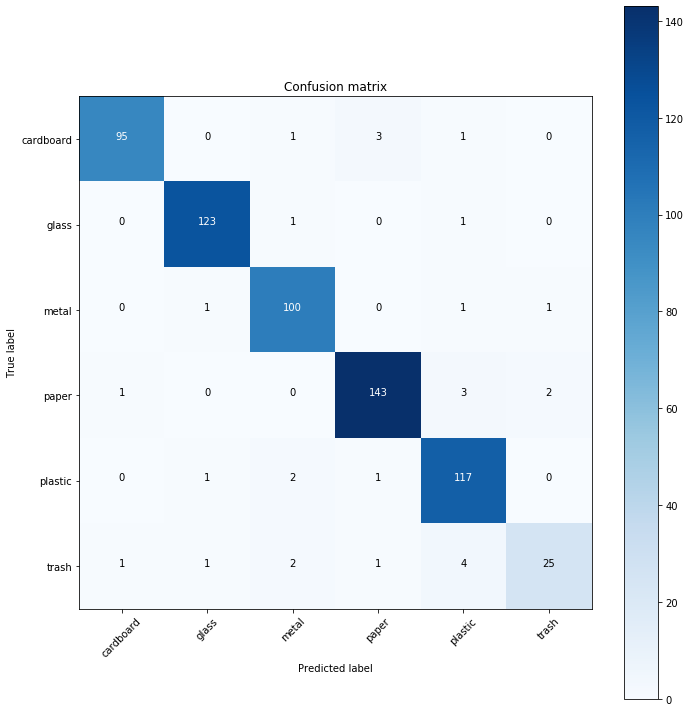

In [0]:
cm = confusion_matrix(test_labels.cpu(), test_preds.argmax(dim=1).cpu())

plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, class_names)

In [12]:
model = torchvision.models.densenet161(pretrained=True)
model.cuda()
model.load_state_dict(torch.load("/content/drive/My Drive/modelThreeDec2.pt"))

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:01<00:00, 61.1MB/s]


<All keys matched successfully>

In [35]:
model = torchvision.models.densenet161(pretrained=True)
model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

minibatches = 5

train_losses, train_accs = [], []
val_losses, val_accs = [], []

for epoch in range(15):  # loop over the dataset multiple times

    running_loss = 0.0
    model.train()
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        pred = outputs.data.max(1)[1]
        matches = labels == pred
        accuracy = matches.float().mean()

        # print statistics
        running_loss += loss.item()
        if i % minibatches == minibatches - 1:    # print every n mini-batches
            print('[%d, %5d] loss: %.3f accuracy: %.3f itemLoss: %.3f' %
                  (epoch + 1, i + 1, running_loss / minibatches, accuracy, loss.item()))
            running_loss = 0.0

        train_losses.append(loss.item())
        train_accs.append(accuracy.item())
    
    model.eval()
    val_loss, correct = 0., 0
    total = 0
    with torch.no_grad():
      for data in val_loader:
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = model(inputs)
        val_loss += criterion(outputs, labels).item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the validation images: %f %%' % (
    100 * correct / total))

    val_loss /= len(val_loader)
    acc = correct / len(val_loader)

    val_losses.append(val_loss)
    val_accs.append(acc)

print('Finished Training')

[1,     5] loss: 6.144 accuracy: 0.320 itemLoss: 3.795
[1,    10] loss: 2.731 accuracy: 0.640 itemLoss: 1.909
[1,    15] loss: 1.302 accuracy: 0.480 itemLoss: 1.536
[1,    20] loss: 0.932 accuracy: 0.760 itemLoss: 0.953
[1,    25] loss: 0.799 accuracy: 0.920 itemLoss: 0.393
[1,    30] loss: 0.810 accuracy: 0.760 itemLoss: 0.612
[1,    35] loss: 0.628 accuracy: 0.880 itemLoss: 0.469
[1,    40] loss: 0.585 accuracy: 0.840 itemLoss: 0.727
[1,    45] loss: 0.434 accuracy: 0.960 itemLoss: 0.314
[1,    50] loss: 0.479 accuracy: 0.920 itemLoss: 0.292
Accuracy of the network on the validation images: 82.006369 %
[2,     5] loss: 0.370 accuracy: 0.880 itemLoss: 0.509
[2,    10] loss: 0.486 accuracy: 0.920 itemLoss: 0.278
[2,    15] loss: 0.415 accuracy: 0.880 itemLoss: 0.372
[2,    20] loss: 0.407 accuracy: 0.720 itemLoss: 0.558
[2,    25] loss: 0.317 accuracy: 0.960 itemLoss: 0.304
[2,    30] loss: 0.425 accuracy: 1.000 itemLoss: 0.133
[2,    35] loss: 0.358 accuracy: 0.800 itemLoss: 0.729
[2,

In [0]:
# torch.save(model.state_dict(), "/content/drive/My Drive/modelDec8.pt")

In [0]:
@torch.no_grad()
def get_all_preds_top_loss(model, loader):
    all_preds = torch.tensor([])
    all_labels = torch.tensor([])
    all_labels = all_labels.cuda()
    all_preds = all_preds.cuda()
    for batch in loader:
        images, labels = batch
        images = images.cuda()
        labels = labels.float().cuda()
        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
        all_labels = torch.cat((all_labels, labels), dim=0)
    probabilities = all_preds[(all_preds.argmax(dim=1) == 4) & (all_labels == 5)]
    return all_preds, all_labels, probabilities

In [0]:
model.eval()

with torch.no_grad():
    prediction_loader = test_loader
    test_preds, test_labels, test_probabilities = get_all_preds_top_loss(model, prediction_loader)

In [56]:
preds_correct = get_num_correct(test_preds, test_labels)

print('total correct:', preds_correct)
print('accuracy:', preds_correct / len(test_set))

total correct: 588
accuracy: 0.930379746835443


In [59]:
# print(test_probabilities.shape)
n = 4
the_sum = torch.sum(test_probabilities[n,:6])
print(test_probabilities[n,:6] / the_sum)
# print(test_preds.shape)

tensor([0.0903, 0.1742, 0.1861, 0.1639, 0.1983, 0.1872], device='cuda:0')


In [0]:
# !cp -r dataset-test '/content/drive/My Drive/'

Confusion matrix, without normalization
[[ 95   0   0   3   2   0]
 [  0 113   6   0   6   0]
 [  0   0 103   0   0   0]
 [  0   3   2 140   2   2]
 [  0   3   2   1 115   0]
 [  0   0   4   3   5  22]]
(5.5, -0.5)


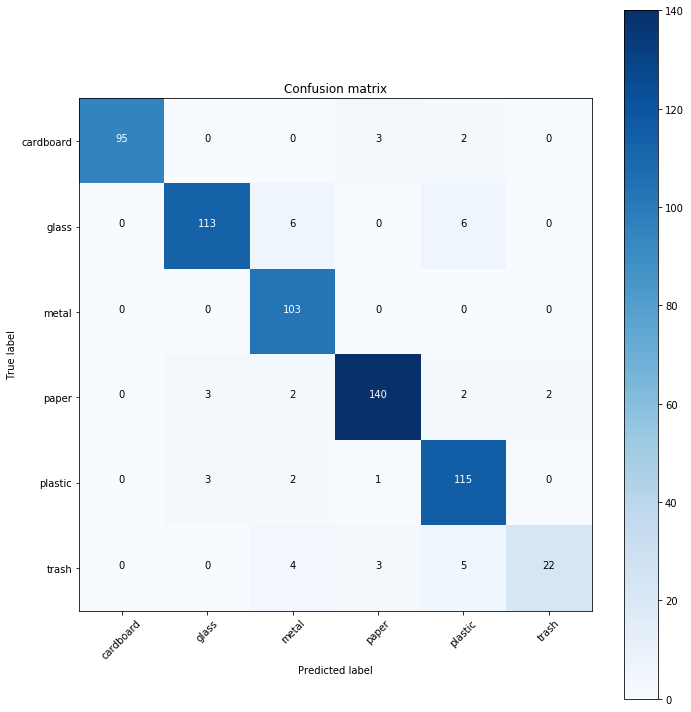

In [49]:
stacked = torch.stack(
    (
        test_labels
        ,test_preds.argmax(dim=1).float()
    )
    ,dim=1
)

cmt = torch.zeros(6, 6, dtype=torch.int64)
stacked.shape

for p in stacked.int():
    tl, pl = p.tolist()
    cmt[tl, pl] = cmt[tl, pl] + 1

cmt

cm = confusion_matrix(test_labels.cpu(), test_preds.argmax(dim=1).cpu())

plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, class_names)

In [60]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    model.train()
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        pred = outputs.data.max(1)[1]
        matches = labels == pred
        accuracy = matches.float().mean()

        # print statistics
        running_loss += loss.item()
        if i % minibatches == minibatches - 1:    # print every n mini-batches
            print('[%d, %5d] loss: %.3f accuracy: %.3f itemLoss: %.3f' %
                  (epoch + 1, i + 1, running_loss / minibatches, accuracy, loss.item()))
            running_loss = 0.0

        train_losses.append(loss.item())
        train_accs.append(accuracy.item())
    
    model.eval()
    val_loss, correct = 0., 0
    total = 0
    with torch.no_grad():
      for data in val_loader:
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = model(inputs)
        val_loss += criterion(outputs, labels).item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the validation images: %f %%' % (
    100 * correct / total))

    val_loss /= len(val_loader)
    acc = correct / len(val_loader)

    val_losses.append(val_loss)
    val_accs.append(acc)

print('Finished Training')

[1,     5] loss: 0.022 accuracy: 1.000 itemLoss: 0.010
[1,    10] loss: 0.011 accuracy: 1.000 itemLoss: 0.009
[1,    15] loss: 0.029 accuracy: 1.000 itemLoss: 0.018
[1,    20] loss: 0.017 accuracy: 1.000 itemLoss: 0.004
[1,    25] loss: 0.013 accuracy: 1.000 itemLoss: 0.016
[1,    30] loss: 0.007 accuracy: 1.000 itemLoss: 0.002
[1,    35] loss: 0.024 accuracy: 1.000 itemLoss: 0.010
[1,    40] loss: 0.014 accuracy: 1.000 itemLoss: 0.010
[1,    45] loss: 0.016 accuracy: 1.000 itemLoss: 0.003
[1,    50] loss: 0.027 accuracy: 1.000 itemLoss: 0.012
Accuracy of the network on the validation images: 92.356688 %
[2,     5] loss: 0.034 accuracy: 0.960 itemLoss: 0.068
[2,    10] loss: 0.031 accuracy: 1.000 itemLoss: 0.006
[2,    15] loss: 0.043 accuracy: 1.000 itemLoss: 0.026
[2,    20] loss: 0.013 accuracy: 1.000 itemLoss: 0.005
[2,    25] loss: 0.031 accuracy: 1.000 itemLoss: 0.033
[2,    30] loss: 0.013 accuracy: 1.000 itemLoss: 0.012
[2,    35] loss: 0.025 accuracy: 1.000 itemLoss: 0.011
[2,

In [61]:
model.eval()

with torch.no_grad():
    prediction_loader = test_loader
    test_preds, test_labels, test_probabilities = get_all_preds_top_loss(model, prediction_loader)

preds_correct = get_num_correct(test_preds, test_labels)

print('total correct:', preds_correct)
print('accuracy:', preds_correct / len(test_set))

total correct: 595
accuracy: 0.9414556962025317


In [0]:
# torch.save(model.state_dict(), "/content/drive/My Drive/modelTwoDec8.pt")

In [68]:
model = torchvision.models.densenet161(pretrained=True)
model.cuda()
model.load_state_dict(torch.load("/content/drive/My Drive/modelThreeDec2.pt"))

<All keys matched successfully>

In [0]:
@torch.no_grad()
def get_all_preds_top_loss(model, loader):
    all_preds = torch.tensor([])
    all_labels = torch.tensor([])
    all_labels = all_labels.cuda()
    all_preds = all_preds.cuda()
    for batch in loader:
        images, labels = batch
        images = images.cuda()
        labels = labels.float().cuda()
        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
        all_labels = torch.cat((all_labels, labels), dim=0)
    probabilities = all_preds[(all_preds.argmax(dim=1) == 2) & (all_labels == 4)]
    return all_preds, all_labels, probabilities

In [85]:
model.eval()

with torch.no_grad():
    prediction_loader = test_loader
    test_preds, test_labels, test_probabilities = get_all_preds_top_loss(model, prediction_loader)

preds_correct = get_num_correct(test_preds, test_labels)

print('total correct:', preds_correct)
print('accuracy:', preds_correct / len(test_set))

total correct: 620
accuracy: 0.9810126582278481


Confusion matrix, without normalization
[[ 98   0   0   1   1   0]
 [  0 123   2   0   0   0]
 [  0   0 103   0   0   0]
 [  0   0   0 146   2   1]
 [  0   1   1   0 119   0]
 [  0   1   1   0   1  31]]
(5.5, -0.5)


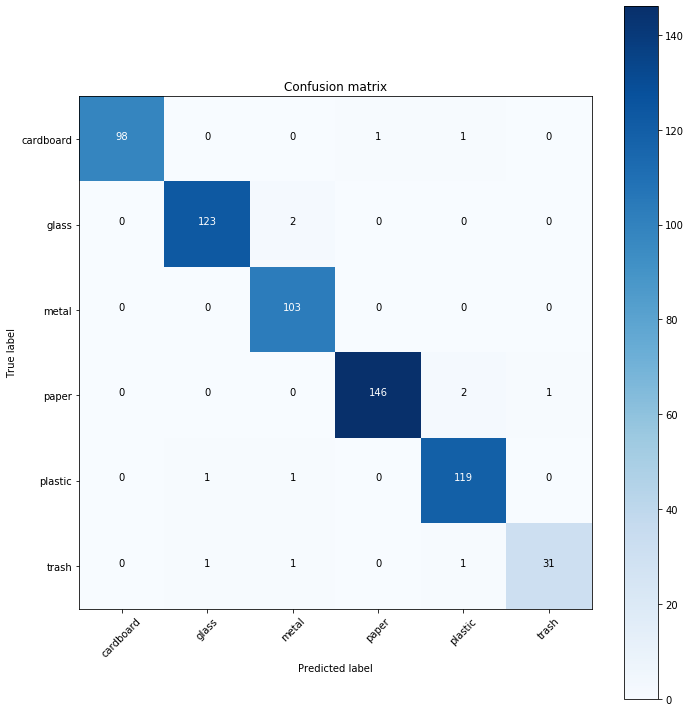

In [70]:
stacked = torch.stack(
    (
        test_labels
        ,test_preds.argmax(dim=1).float()
    )
    ,dim=1
)

cmt = torch.zeros(6, 6, dtype=torch.int64)
stacked.shape

for p in stacked.int():
    tl, pl = p.tolist()
    cmt[tl, pl] = cmt[tl, pl] + 1

cmt

cm = confusion_matrix(test_labels.cpu(), test_preds.argmax(dim=1).cpu())

plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, class_names)

In [71]:
# print(test_probabilities.shape)
n = 0
the_sum = torch.sum(test_probabilities[n,:6])
print(test_probabilities[n,:6] / the_sum)
# print(test_preds.shape)

tensor([0.1070, 0.1405, 0.0698, 0.1365, 0.2763, 0.2699], device='cuda:0')


In [74]:
# print(test_probabilities.shape)
n = 0
the_sum = torch.sum(test_probabilities[n,:6])
print(test_probabilities[n,:6] / the_sum)
# print(test_preds.shape)

tensor([0.1345, 0.1544, 0.1002, 0.2289, 0.2338, 0.1481], device='cuda:0')


In [77]:
# print(test_probabilities.shape)
n = 0
the_sum = torch.sum(test_probabilities[n,:6])
print(test_probabilities[n,:6] / the_sum)
# print(test_preds.shape)

tensor([0.1685, 0.1128, 0.1690, 0.2588, 0.2082, 0.0827], device='cuda:0')


In [80]:
# print(test_probabilities.shape)
n = 0
the_sum = torch.sum(test_probabilities[n,:6])
print(test_probabilities[n,:6] / the_sum)
# print(test_preds.shape)

tensor([0.1392, 0.1507, 0.1485, 0.1757, 0.1815, 0.2043], device='cuda:0')


In [83]:
# print(test_probabilities.shape) 2 bottom
n = 0
the_sum = torch.sum(test_probabilities[n,:6])
print(test_probabilities[n,:6] / the_sum)
# print(test_preds.shape)

tensor([0.0550, 0.1037, 0.2787, 0.1614, 0.1960, 0.2052], device='cuda:0')


In [86]:
# print(test_probabilities.shape) 2 up
n = 0
the_sum = torch.sum(test_probabilities[n,:6])
print(test_probabilities[n,:6] / the_sum)
# print(test_preds.shape)

tensor([0.1390, 0.1313, 0.3069, 0.1605, 0.1818, 0.0804], device='cuda:0')
